# Further Research

Our previous points for further improving were:

1. Adding useful features to the data.
2. Experimenting with the classifers:    
    a. Using one user's classifier to predict another user's scores.    
    b. Try a different ML model.
3. Try aggregating entire dataset for learning and then predicting.
4. Better and faster interface for extracting the data once, and dynamicly choosing users to predict upon.

#### Imports

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
import pandas as pd
from textblob import TextBlob

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Extracting dataset

In [2]:
from ReviewsData import *

In [3]:
N_USERS = 10
review_data = ReviewData(FILE_PATH, max_users=N_USERS)

2020-09-17 21:29:55,768 - DEBUG - Starting population of 10 users's reviews from 7911684 reviews in file.
2020-09-17 21:34:43,675 - DEBUG - Populated data structure successfully.


In [4]:
users = review_data.get_users_list()
print(users)

['A141HP4LYPWMSR', 'A328S9RN3U5M68', 'A1I7QGUDP043DG', 'A1M5405JH9THP9', 'ATXL536YX71TR', 'A3QYDL5CDNYN66', 'AQJVNDW6YZFQS', 'AD4CDZK7D31XP', 'A3Q4S5DFVPB70D', 'A2P7UB02HAVEPB']


## Text cleaning tools

Removing punctuation & stopwords, tokenizing, and stemming.

In [5]:
import string
import re
import nltk

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

In [6]:
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

## 1. Learning from certain user's data - with Feature Engineering

We will be creating and adding feature we find relevant for our task. Some will come from our domain knowledge (our knowledge and intuition approaching of the task), and all from analysis of usefullness.

We will:

1. Analyze existing features, are they useful to us?:
    1. ```'time'```
    2. ```'helpfulness'```
    3. ```'summary'```
2. Create new features:
    1. Length analysis: Count words, characters, and sentences, and get average word and sentence lengths.
    2. Sentiment Analysis: using some pre-trained models of representing the **emotions** in the reviews.
    3. Word Frequency: apply N-Grams vectorization (an improvement on our previous try).

In [61]:
user = users[0]
user_reviews = review_data.get_user_reviews(user)
data = pd.DataFrame.from_records(user_reviews)
data = data.drop(columns=['productId', 'helpfulness', 'userId', 'profileName'])
data

2020-09-17 22:12:38,935 - DEBUG - Starting search for user reviews.
2020-09-17 22:12:38,936 - DEBUG - Returning user A141HP4LYPWMSR's  3649 reviews.


,score,time,summary,text
0,3.0,1182729600,"""There Is So Much Darkness Now ~ Come For The ...","Synopsis: On the daily trek from Juarez, Mexic..."
1,4.0,1161820800,We Are All Either Kings Or Pawns In The Game O...,The '02 release of `The Count of Monte Cristo'...
2,5.0,1170201600,"""Does Anyone Really Know?"" ~ Shamanic Excess A...",'The Doors' were one of the greatest rock and ...
3,5.0,1211414400,"""Bob's Your Uncle""",Released in `64 `Mary Poppins' is without ques...
4,3.0,1146787200,"Attack of the Giant Playmate, I Mean Leeches",11 out of 12 reviewers (now 12 with mine) are ...
...,...,...,...,...
3644,5.0,1304553600,"""In The Eyes Of God, We Are All Equal"" ~ Waiti...",`Earth' is the second film in Deepa Mehta's ci...
3645,5.0,1126483200,"""COME INTO ME!"" ~ Perceiving The Metaphysica...",What is it about this 1973 film dealing with t...
3646,5.0,1128816000,"""The Story Maybe Apocraphal, But I Believe It""","Carl Kolchak, the Night Stalker! Truly one of ..."
3647,3.0,1194912000,"""We Are One Smart Kid""",Disney's 'Meet the Robinson' is a fast paced a...


In [62]:
logging.basicConfig(level=logging.CRITICAL)

In [63]:
data['word_count'] = data["text"].apply(lambda x: len(str(x).split(" ")))
data['char_count'] = data["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
data['sentence_count'] = data["text"].apply(lambda x: len(str(x).split(".")))
data['avg_word_length'] = data['char_count'] / data['word_count']
data['avg_sentence_length'] = data['word_count'] / data['sentence_count']
data['sentiment'] = data['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
data.head()

,score,time,summary,text,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,sentiment
0,3.0,1182729600,"""There Is So Much Darkness Now ~ Come For The ...","Synopsis: On the daily trek from Juarez, Mexic...",297,1546,14,5.205387,21.214286,0.012931
1,4.0,1161820800,We Are All Either Kings Or Pawns In The Game O...,The '02 release of `The Count of Monte Cristo'...,99,487,5,4.919192,19.800000,0.550926
2,5.0,1170201600,"""Does Anyone Really Know?"" ~ Shamanic Excess A...",'The Doors' were one of the greatest rock and ...,414,2045,14,4.939614,29.571429,0.229326
3,5.0,1211414400,"""Bob's Your Uncle""",Released in `64 `Mary Poppins' is without ques...,117,579,6,4.948718,19.500000,0.335294
4,3.0,1146787200,"Attack of the Giant Playmate, I Mean Leeches",11 out of 12 reviewers (now 12 with mine) are ...,121,579,8,4.785124,15.125000,0.042208


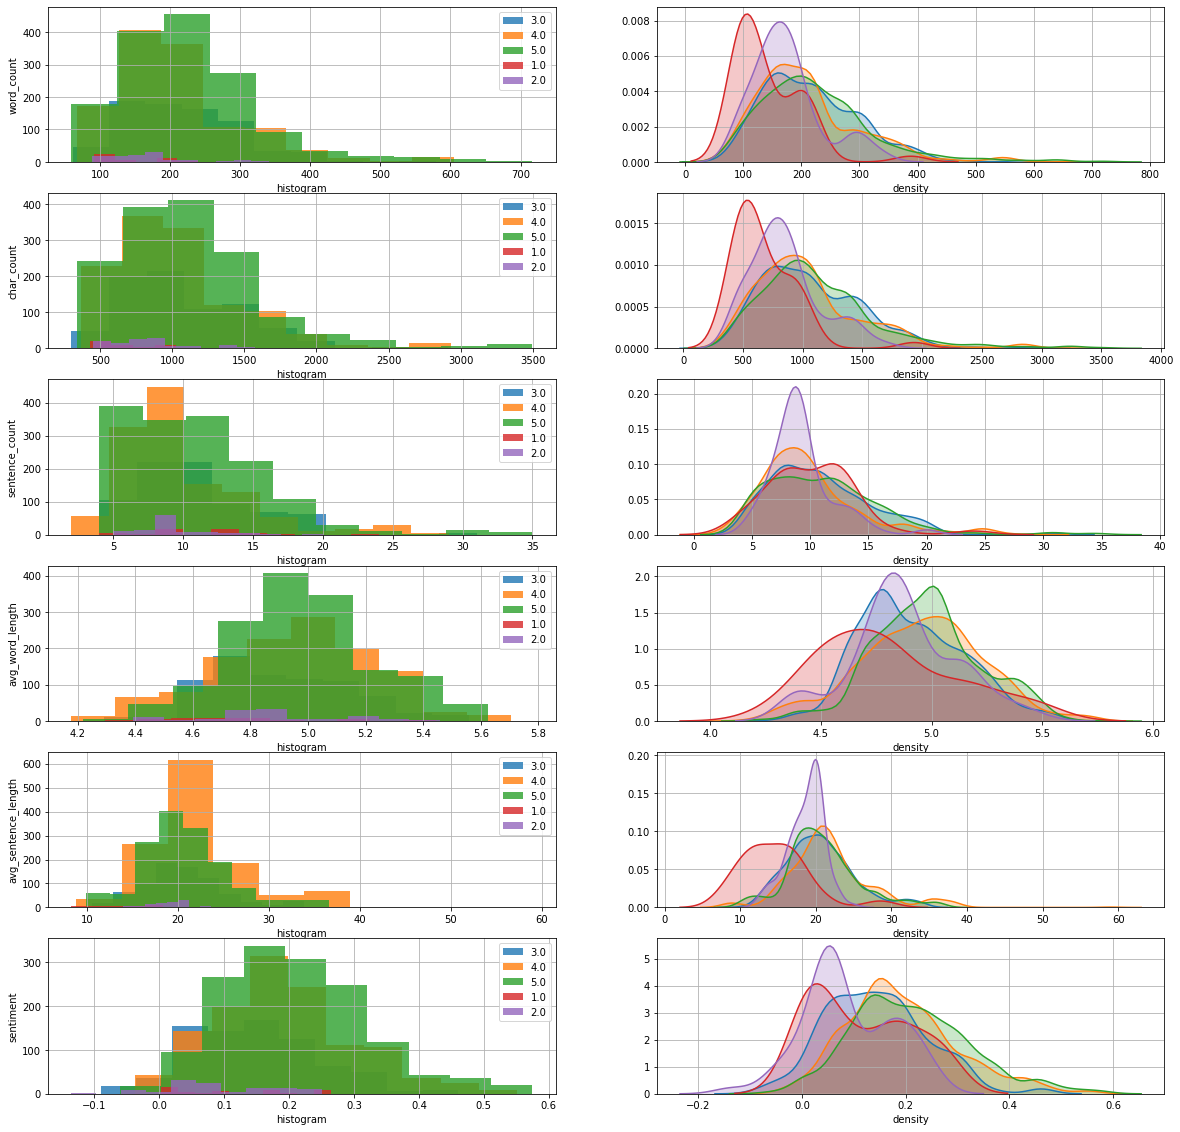

In [64]:
x_s = ['word_count', 'char_count', 'sentence_count', 'avg_word_length', 'avg_sentence_length', 'sentiment']
y = 'score'

fig, ax = plt.subplots(len(x_s), 2, figsize=(20, 20))

for row, x in enumerate(x_s):
#     ax[row, :].title(x, fontsize=12)
    for i in data[y].unique():
        sns.distplot(data[data[y]==i][x], hist=True, kde=False, 
                     bins=10, hist_kws={"alpha":0.8}, 
                     axlabel="histogram", ax=ax[row, 0])
        sns.distplot(data[data[y]==i][x], hist=False, kde=True, 
                     kde_kws={"shade":True}, axlabel="density",   
                     ax=ax[row, 1])
    ax[row, 0].grid(True)
    ax[row, 0].set_ylabel(x)
    ax[row, 0].legend(data[y].unique())
    ax[row, 1].grid(True)
plt.show()

We can see that the features corresponding to the length of the review - word or character counters for example - are quite predictive of the score.

However, it is important to note that they are not enough to predict solely by. As can be seen in the following scatter plot, the better score range between all ```word_count``` values, meaning we can't predict successfully by this feature, even on our sample. We still see though that the lower scores correlate well with low word counts, meaning this is useful information for our classifiers.

So, we will use one of those features by adding it to our random forest classifier.

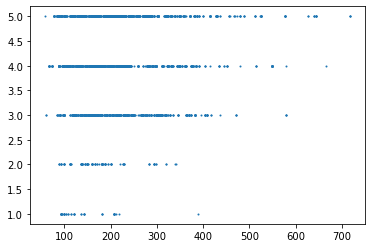

In [65]:
plt.scatter(data['word_count'], data['score'].apply(lambda x: int(float(x))), s=1.0)

In addition, we can see (as expected) that the ```sentiment``` feature is clearly correlated with the scores - positive sentiments usually mean better scores and vice versa.

Lastly, worth noting we analyzed these features on **a single user's data**. We could do this on the entire dataset, but I think this was convincing enough.

### Feature Selection

We could implement some feature selection/reduction techniques here, if I had some more time: the issue is that the different features are not on the same scale therefore their variance can't be measured in a "fair" manner. Need to normalise them and then apply the VarianceThreshold routine for example.

#### Split train/test

In [67]:
data = data.drop(columns=['char_count', 'sentence_count', 'avg_word_length'])
data.head()

,score,time,summary,text,word_count,avg_sentence_length,sentiment
0,3.0,1182729600,"""There Is So Much Darkness Now ~ Come For The ...","Synopsis: On the daily trek from Juarez, Mexic...",297,21.214286,0.012931
1,4.0,1161820800,We Are All Either Kings Or Pawns In The Game O...,The '02 release of `The Count of Monte Cristo'...,99,19.800000,0.550926
2,5.0,1170201600,"""Does Anyone Really Know?"" ~ Shamanic Excess A...",'The Doors' were one of the greatest rock and ...,414,29.571429,0.229326
3,5.0,1211414400,"""Bob's Your Uncle""",Released in `64 `Mary Poppins' is without ques...,117,19.500000,0.335294
4,3.0,1146787200,"Attack of the Giant Playmate, I Mean Leeches",11 out of 12 reviewers (now 12 with mine) are ...,121,15.125000,0.042208


In [68]:
X = data.drop(columns=['score'])
Y = data['score']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Vectorize Text

In [69]:
def vectorize_text_tdif(data, train, test):
    vectorizer = TfidfVectorizer(analyzer=clean_text)
    vect_fit = vectorizer.fit(data)
    transformed_train = vect_fit.transform(train)
    transformed_test = vect_fit.transform(test)
    return transformed_train, transformed_test

def vectorize_text_BoW(data, train, test):
    vectorizer = CountVectorizer(analyzer=clean_text)
    vect_fit = vectorizer.fit(data)
    transformed_train = vect_fit.transform(train)
    transformed_test = vect_fit.transform(test)
    return transformed_train, transformed_test

In [70]:
X_train_text_vect, X_test_text_vect = vectorize_text_tdif(data['text'], X_train['text'], X_test['text'])
X_train_summary_vect, X_test_summary_vect = vectorize_text_tdif(data['summary'], X_train['summary'], X_test['summary'])

In [84]:
X_train_vect = pd.concat([X_train[['word_count', 'avg_sentence_length', 'sentiment']].reset_index(drop=True),
                          pd.DataFrame(X_train_summary_vect.toarray()),
                          pd.DataFrame(X_train_text_vect.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['word_count', 'avg_sentence_length', 'sentiment']].reset_index(drop=True),
                         pd.DataFrame(X_test_summary_vect.toarray()),
                         pd.DataFrame(X_test_text_vect.toarray())], axis=1)

X_train_vect.head()

,word_count,avg_sentence_length,sentiment,0,1,2,3,4,5,6,...,12389,12390,12391,12392,12393,12394,12395,12396,12397,12398
0,84,21.000000,0.487500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,222,22.200000,0.244192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,469,29.312500,0.126812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,88,8.800000,0.319792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,319,22.785714,0.073325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Classifying

We will use Random Forests.

In [72]:
def get_rf_model(X_train_vect, y_train):
    rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)
    rf_model = rf.fit(X_train_vect, y_train)
    return rf_model

def test_rf_model(rf_model, X_test_vect, y_test):
    logging.basicConfig(level=logging.CRITICAL)
    y_pred = rf_model.predict(X_test_vect)

    precision, recall, fscore, train_support = score(y_test, y_pred, labels=[1.0, 2.0, 3.0, 4.0, 5.0], average=None)
    print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
        precision, recall, fscore, acs(y_test,y_pred)))

    # Making the Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    class_label = [1.0, 2.0, 3.0, 4.0, 5.0]
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Testing the results

In [86]:
rf_model = get_rf_model(X_train_vect, y_train)

C:\Users\dantc\anaconda3\envs\snap_env\lib\site-packages\numpy\lib\arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
2020-09-17 22:20:50,182 - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001F461B6F128>
2020-09-17 22:20:50,182 - DEBUG - Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001F461B6F128> on colorbar
2020-09-17 22:20:50,183 - DEBUG - Setting pcolormesh


Precision: [1.         1.         0.99319728 0.97033898 0.95238095] / Recall: [1.         0.96       0.93589744 0.95416667 0.99667774] / F1-Score: [1.         0.97959184 0.96369637 0.96218487 0.97402597] / Accuracy: 0.9684931506849315


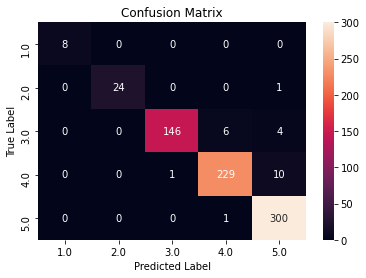

In [88]:
test_rf_model(rf_model, X_test_vect, y_test)

Seems like a good classifier.

## 2. Aggregating entire dataset for learning and then predicting.

In [17]:
allusers_reviews = review_data.get_all_reviews()

allusers_data = pd.DataFrame.from_records(allusers_reviews)
allusers_data = allusers_data.drop(columns=['profileName', 'helpfulness'])
allusers_data

2020-09-17 19:56:40,169 - DEBUG - Starting retrieval of all user reviews.
2020-09-17 19:56:40,172 - DEBUG - Done


,productId,userId,score,time,summary,text
0,B003AI2VGA,A141HP4LYPWMSR,3.0,1182729600,"""There Is So Much Darkness Now ~ Come For The ...","Synopsis: On the daily trek from Juarez, Mexic..."
1,B000063W1R,A141HP4LYPWMSR,4.0,1161820800,We Are All Either Kings Or Pawns In The Game O...,The '02 release of `The Count of Monte Cristo'...
2,6304286961,A141HP4LYPWMSR,5.0,1170201600,"""Does Anyone Really Know?"" ~ Shamanic Excess A...",'The Doors' were one of the greatest rock and ...
3,5556167281,A141HP4LYPWMSR,5.0,1211414400,"""Bob's Your Uncle""",Released in `64 `Mary Poppins' is without ques...
4,6303998690,A141HP4LYPWMSR,3.0,1146787200,"Attack of the Giant Playmate, I Mean Leeches",11 out of 12 reviewers (now 12 with mine) are ...
...,...,...,...,...,...,...
14924,B0007TFH70,AXMKAXC0TR9AW,5.0,1120176000,Contains All The Hit Songs And Interviews,I am very pleased with this DVD. It includes ...
14925,B0008FXSQU,AXMKAXC0TR9AW,4.0,1131148800,An Enjoyable half hour,As others have listed there are seven (7) Herm...
14926,6304749910,AXMKAXC0TR9AW,5.0,1011744000,A Video to Watch Numerous Times,Whether or not a video or movie deserves an &q...
14927,B00004CS3W,AXMKAXC0TR9AW,5.0,1010880000,This Movie is Timeless,I remember seeing this movie in 1955 when I wa...


In [17]:
X_all = allusers_data[['productId', 'userId', 'time', 'summary', 'text']]
Y_all = allusers_data['score']

X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, Y_all, test_size=0.2, random_state=42)

In [18]:
logging.debug('Starting vectorization.')

X_all_train_vect = dict()
X_all_test_vect = dict()

X_all_train_vect['text'], X_all_test_vect['text'] = vectorize_text_tdif(allusers_data['text'], X_all_train['text'], X_all_test['text'])
X_all_train_vect['summary'], X_all_test_vect['summary'] = vectorize_text_tdif(allusers_data['summary'], X_all_train['summary'], X_all_test['summary'])
X_all_train_vect['productId'], X_all_test_vect['productId'] = vectorize_text_BoW(allusers_data['productId'], X_all_train['productId'], X_all_test['productId'])
X_all_train_vect['userId'], X_all_test_vect['userId'] = vectorize_text_BoW(allusers_data['userId'], X_all_train['userId'], X_all_test['userId'])

logging.debug('Done.')

2020-09-17 07:40:37,793 - DEBUG - Starting vectorization.
2020-09-17 07:44:33,743 - DEBUG - Done.


In [20]:
X_all_train_vect = pd.concat([X_all_train[['time']].reset_index(drop=True),
                              pd.DataFrame(X_all_train_vect['productId'].toarray()),
                              pd.DataFrame(X_all_train_vect['userId'].toarray()),
                              pd.DataFrame(X_all_train_vect['summary'].toarray()),
                              pd.DataFrame(X_all_train_vect['text'].toarray())], axis=1)
X_all_test_vect = pd.concat([X_all_test[['time']].reset_index(drop=True),
                              pd.DataFrame(X_all_test_vect['productId'].toarray()),
                              pd.DataFrame(X_all_test_vect['userId'].toarray()),
                              pd.DataFrame(X_all_test_vect['summary'].toarray()),
                              pd.DataFrame(X_all_test_vect['text'].toarray())], axis=1)

X_all_train_vect.head()

,time,0,1,2,3,4,5,6,7,8,...,43426,43427,43428,43429,43430,43431,43432,43433,43434,43435
0,951696000,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1099267200,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1189382400,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1304812800,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1149897600,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Now testing the orig model on this user's reviews
At the moment we can see that we have issues of memory allocation (due to my 8G RAM PC..). Putting a pin in this and researching other areas.

In [21]:
logging.debug('Fitting model.')
rf_model = get_rf_model(X_all_train_vect, y_all_train)
logging.debug('Done.')

2020-09-17 07:47:42,781 - DEBUG - Fitting model.


MemoryError: Unable to allocate 1.11 GiB for an array with shape (12419, 11943) and data type object